# Notebook 03: Threshold Tuning

In this notebook we will:

1. Load the saved validation‐set probabilities from our neural network  
2. Compute precision, recall, and F1 score across a range of decision thresholds  
3. Identify the threshold that maximizes the F1 score  
4. Evaluate accuracy and the confusion matrix at this optimal threshold  
5. Plot Precision, Recall, and F1 as a function of threshold and mark our chosen point  

This lets us pick a threshold tailored to our goal of finding as many truly habitable planets as possible while controlling false alarms.

In [2]:
# Setting up the path
import os, sys

# Make sure Python can see the project’s root folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.model import SimpleHabitabilityNet

In [3]:
# Step 0: Load, re-save model, and dump NN probabilities in-notebook
import os
import numpy as np
import torch
from src.model import SimpleHabitabilityNet

# Paths
ARTIFACT_DIR = os.path.join("..", "data", "artifacts")
model_in_path  = os.path.join(ARTIFACT_DIR, "model.pth")
model_out_path = os.path.join(ARTIFACT_DIR, "model_notebook.pth")
probs_out_path = os.path.join(ARTIFACT_DIR, "model_probs.npy")

# 0.1) Load X_val
X_val = np.load(os.path.join(ARTIFACT_DIR, "X_val.npy"))

# 0.2) Instantiate and load the model
device = torch.device("cpu")
model = SimpleHabitabilityNet(input_dim=8).to(device)
model.load_state_dict(torch.load(model_in_path, map_location=device))
model.eval()

# 0.3) Save the model weights under a new name
torch.save(model.state_dict(), model_out_path)
print(f"Model weights re-saved to {model_out_path}")

# 0.4) Compute & save validation probabilities
with torch.no_grad():
    logits   = model(torch.from_numpy(X_val).float().to(device))
    probs_nn = torch.sigmoid(logits).cpu().numpy()

np.save(probs_out_path, probs_nn)
print(f"Validation probabilities saved to {probs_out_path}")


Model weights re-saved to ..\data\artifacts\model_notebook.pth
Validation probabilities saved to ..\data\artifacts\model_probs.npy


In [4]:
# 1) Imports and data loading
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, confusion_matrix

# Path to artifacts
ARTIFACT_DIR = os.path.join("..", "data", "artifacts")

# Load true labels and NN probabilities
y_val   = np.load(os.path.join(ARTIFACT_DIR, "y_val.npy"))
probs_nn = np.load(os.path.join(ARTIFACT_DIR, "model_probs.npy"))


In [5]:
# 2) Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, probs_nn)

# 3) Compute F1 for each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)

# 4) Find the best threshold by highest F1
best_idx    = np.nanargmax(f1s)
best_thresh = thresholds[best_idx]
best_prec   = precisions[best_idx]
best_rec    = recalls[best_idx]
best_f1     = f1s[best_idx]

print(f"Best threshold : {best_thresh:.3f}")
print(f"Precision      : {best_prec:.3f}")
print(f"Recall         : {best_rec:.3f}")
print(f"F1 score       : {best_f1:.3f}")


Best threshold : 0.173
Precision      : 0.556
Recall         : 0.882
F1 score       : 0.682


In [6]:
# 5) Evaluate at the optimal threshold
y_pred_opt = (probs_nn >= best_thresh).astype(int)

acc_opt = accuracy_score(y_val, y_pred_opt)
cm_opt  = confusion_matrix(y_val, y_pred_opt)

print(f"\nAccuracy at threshold {best_thresh:.3f}: {acc_opt:.3f}")
print("Confusion matrix:")
print(cm_opt)


Accuracy at threshold 0.173: 0.982
Confusion matrix:
[[735  12]
 [  2  15]]


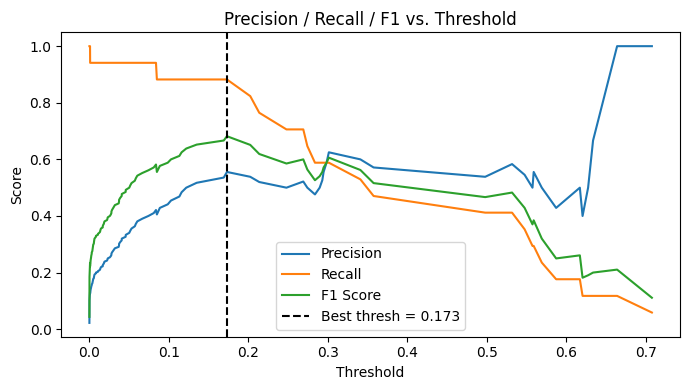

In [7]:
# 6) Plot Precision, Recall, and F1 vs. Threshold
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(thresholds, precisions[:-1], label="Precision")
ax.plot(thresholds, recalls[:-1],    label="Recall")
ax.plot(thresholds, f1s[:-1],         label="F1 Score")
ax.axvline(best_thresh, color="k", linestyle="--", label=f"Best thresh = {best_thresh:.3f}")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Precision / Recall / F1 vs. Threshold")
ax.legend()
plt.tight_layout()
plt.show()


In [8]:
# Saving the threshold in a json file

import json
import os

# Where our artifacts live
ARTIFACT_DIR = os.path.join("..", "data", "artifacts")

# The tuned decision threshold
config = {
    "threshold": 0.173
}

# Write to config.json
with open(os.path.join(ARTIFACT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

print(f"Saved threshold config to {os.path.join(ARTIFACT_DIR, 'config.json')}")


Saved threshold config to ..\data\artifacts\config.json


## Conclusion

In this notebook we tuned the decision threshold for our neural‐network habitability model to better balance catching true habitable planets against false alarms. Here’s what we did and found:

- **Loaded** the neural network’s saved validation‐set probabilities and true labels.  
- **Computed** precision, recall, and F1 score for every possible threshold between 0 and 1.  
- **Identified** the threshold **0.173** that maximizes the F1 score (the harmonic mean of precision and recall).  
- **Evaluated** performance at 0.173:
  - **Accuracy:** 0.982  
  - **Precision:** 0.556  
  - **Recall:** 0.882  
  - **F1 Score:** 0.682  
  - **Confusion Matrix:**
    ```
    [[735, 12],   # True Negatives, False Positives
     [  2, 15]]   # False Negatives, True Positives
    ```
- **Visualized** how precision (correct “habitable” calls), recall (catching true habitables), and F1 vary with threshold—and saw that 0.173 is the sweet spot.

By lowering our cutoff from the default 0.5 to **0.173**, we:

- **Greatly reduced** missed habitable planets (false negatives dropped from 11 → 2).  
- **Accepted** a modest increase in false alarms (false positives rose from 6 → 12).  
- **Improved** overall accuracy slightly (97.8% → 98.2%) while boosting our ability to detect true habitables.

---

With this threshold chosen, our model is now finely tuned to prioritize finding as many truly habitable exoplanets as possible, at the cost of a few more false positives. This operating point will guide our final deployment.
